In [ ]:
!pip install -q vizdoom==1.2.4 stable_baselines3==2.5.0 gymnasium==1.0.0 numpy==2.0.2 torch==2.5 tensorboard==2.18.0 tensorflow==2.18.0

In [ ]:
import stable_baselines3
import vizdoom
import os
import gymnasium

In [ ]:
!python3 ppo_pretraining.py

Restricted action space, to do discrete instead of mulitbinary, which restricts the agent from doing multiple actions at a time. By doing so he has to actively decide between walking and shooting ==> which hopefully should lead to him only shooting when needed to, to solve the biggest issue we currently see(Constant shooting without reason) ==> didn't work still very stuuuuuupid

In [ ]:
%%writefile vizdoom_env.py
import gymnasium
import vizdoom as vzd
import numpy as np
from torch.utils.tensorboard import SummaryWriter

def create_vizdoom_env():
    game = vzd.DoomGame()
    game.load_config("scenarios/move_n_avoid/deadly_corridor.cfg")
    game.set_depth_buffer_enabled(True) 
    game.set_labels_buffer_enabled(True)
    game.set_objects_info_enabled(True)
    
    class VizDoomGymEnv(gymnasium.Env):
        def __init__(self, game):
            self.game = game
            self.game.init()
            self.step_count = 0
            self.action_space = gymnasium.spaces.MultiBinary(len(self.game.get_available_buttons())) 
            self.observation_space = gymnasium.spaces.Box(
                low=0, 
                high=255, 
                shape=(self.game.get_screen_height(), self.game.get_screen_width(), 3),  
                dtype=np.uint8
            )
            self.kill_State = 0   
            self.ammo = 52
            self.health = 100
            self.damage_taken = 0
            self.HITCOUNT = 0
            self.episode_count = 0
            self.writer = SummaryWriter(f"custom_metrics/env_0")
            
        
        def reset(self, seed=None, options=None):
            super().reset(seed=seed)
            self.game.new_episode()
            self.kill_State = 0
            self.ammo = 52
            self.health = 100
            self.damage_taken = 0
            self.HITCOUNT = 0
            state = self.game.get_state()
            return self._process_observation(state), {}

        # Applying reward shaping and logging custom metrics
        # We experimented a lot with reward shaping, generally we tracked everything we tried,but we can't push all of it. This marks the final reward shaping. 
        # We divide the final return by 1000, because we found some sources suggesting that this might improve model performance. 
        def step(self, action):
            done = self.game.is_episode_finished()
            action = action.astype(int).tolist()
            reward = self.game.make_action(action)
            
            if self.game.get_state() is not None:
                game_variables = self.game.get_state().game_variables
                health, damage_taken, HITCOUNT, KILLCOUNT, ammo, position_x = game_variables
                reward += position_x * 0.01moving
                health_delta = health - self.health
                self.health = health
                HITCOUNT_delta = HITCOUNT - self.HITCOUNT
                self.HITCOUNT = HITCOUNT
                ammo_delta = ammo - self.ammo
                self.ammo = ammo
                if HITCOUNT_delta > 0:
                    reward += HITCOUNT * 5
                if action[2] and HITCOUNT_delta <= 0:
                    reward -= 2.0
            
            if done:
                ammo = self.game.get_game_variable(vzd.SELECTED_WEAPON_AMMO)
                health = self.game.get_game_variable(vzd.HEALTH)
                position_x = self.game.get_game_variable(vzd.POSITION_X)
                self.game.new_episode()
                self.kill_State = 0
                outcome = 0 if health <= 0 else 1
                self.writer.add_scalar("Game/Kills", self.HITCOUNT, self.episode_count)
                self.writer.add_scalar("Game/Outcome", outcome, self.episode_count)
                self.writer.add_scalar("Game/AmmoRemaining", ammo, self.episode_count)
                self.writer.add_scalar("Game/Health", health, self.episode_count)
                self.writer.add_scalar("Game/Reward", reward, self.episode_count)
                self.writer.add_scalar("Game/Progress", position_x, self.episode_count)
                
                
                
                self.episode_count += 1
                return (
                    np.zeros(self.observation_space.shape, dtype=np.uint8), 
                    reward / 1000,  
                    done,
                    False,  
                    {},  
                )
            
            state = self.game.get_state()
            if state is None:
                return (
                    np.zeros(self.observation_space.shape, dtype=np.uint8), 
                    reward / 1000,
                    done,
                    False,
                    {},
                )
            
            return self._process_observation(state), reward / 1000, done, False, {}
        
        def _is_near_wall(self):
            state = self.game.get_state()
            if state is None:
                return False
            depth_buffer = state.depth_buffer
            if depth_buffer is None:
                return False
            
            min_depth = np.min(depth_buffer)
            WALL_THRESHOLD = 0  # Adjust as needed
            return min_depth < WALL_THRESHOLD

        # This function intially existed ,because we tried to do image processing on the frames and analyze if it enhanced performance. Currently this isn`'t doing something valuable. '
        def _process_observation(self, state):
            if state is None:
                return np.zeros(self.observation_space.shape, dtype=np.uint8)
            screen_buffer = state.screen_buffer.copy()
            return screen_buffer

        def render(self):
            state = self.game.get_state()
            if state is None:
                return np.zeros(self.observation_space.shape, dtype=np.uint8)
            return state.screen_buffer
        
        def close(self):
            self.writer.close()
            self.game.close()

    return VizDoomGymEnv(game)


In [ ]:
%%writefile ppo_pretraining.py
import gymnasium
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import DummyVecEnv,make_vec_env
from vizdoom_env import create_vizdoom_env  
import os 

# environment for each map
def make_env(map_name):
    """
    Utility function for creating a single environment.
    :param map_name: Name of the map configuration.
    :return: Callable function to create the environment.
    """
    return lambda: create_vizdoom_env(map=map_name)  # Ensure your `create_vizdoom_env` handles the `map` argument

if __name__ == '__main__':
    model_path = "ppo_vizdoom_model.zip"
    # Use SubprocVecEnv to handle multiple parallel environments
    envs = make_vec_env(lambda: create_vizdoom_env(), n_envs=1)  # Pass a callable
    # envs = DummyVecEnv([make_env(map_name) for map_name in maps])

    print(os.path.exists(model_path))

    if os.path.exists(model_path):
        model = PPO.load(model_path, envs,learning_rate=1e-4, verbose=1,tensorboard_log="./ppo_vizdoom_tensorboard/", device="cuda")
        model.set_env(env=envs)
    else:
        model = PPO("CnnPolicy",
            envs,
            n_steps=2048,
            learning_rate=1e-4,
            ent_coef=0.01,
            clip_range=0.2,
            gamma=0.99,
            gae_lambda=0.95,
            verbose=1,
            tensorboard_log="./ppo_vizdoom_tensorboard/",
            device="cuda")
    
    timesteps= 
    model.learn(timesteps,tb_log_name=f"PPO")
    model.save(f"{model_path}")
    envs.close()

In [ ]:
%%writefile scenarios/move_n_avoid/deadly_corridor.cfg
doom_scenario_path = deadly_corridor.wad

# Skill 5 is reccomanded for the scenario to be a challenge.
doom_skill = 5
#lvl_2 has ammo = 26
#lvl_5 has ammo=52

# Rewards
death_penalty = 1000

# Rendering options
screen_resolution = RES_160X120
screen_format = BGR24
render_hud = True
render_crosshair = True
render_weapon = True	
render_decals = False
render_particles = False
window_visible = False	

# Make episodes start in the first tic
episode_start_time = 1

# Make episodes finish after 2100 actions (tics)
episode_timeout = 2100

# Available buttons
available_buttons =
	{
       	TURN_LEFT
        TURN_RIGHT
        ATTACK
        MOVE_LEFT
        MOVE_RIGHT
        MOVE_FORWARD
	}

# Game variables that will be in the state
available_game_variables = { 	
        HEALTH
    	DAMAGE_TAKEN
    	HITCOUNT
        KILLCOUNT
        SELECTED_WEAPON_AMMO
        POSITION_X 
        }
mode = PLAYER

# Extracting the custum metrics which were gathered during a test run, using testModel.py1. 

In [ ]:
import tensorflow as tf
import os

# Directory with event files
log_dir = "custom_metrics/env_0"

# Initialize metric lists
metrics = {
    "Game/Kills": [],
    "Game/Outcome": [],
    "Game/Progress": [],
    "Game/AmmoRemaining": [],
    "Game/Health": [],
    "Game/Reward": [],
    "Game/Position": []  # Optional: remove if not needed
}

# Read all event files*
for event_file in os.listdir(log_dir):
    event_file_path = os.path.join(log_dir, event_file)
    for summary in tf.compat.v1.train.summary_iterator(event_file_path):
        for v in summary.summary.value:
            if v.tag in metrics:
                metrics[v.tag].append(v.simple_value)

# Extract individual metrics
kills = metrics["Game/Kills"]
outcome = metrics["Game/Outcome"]
progress = metrics["Game/Progress"]
ammo = metrics["Game/AmmoRemaining"]
health = metrics["Game/Health"]
reward = metrics["Game/Reward"]
# position = metrics["Game/Position"]  # Optional


# Plotting the custom metrics gathered during a test run of the curriculum level 5 agent

In [ ]:
#Curriculum lvl5
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('default')

fig, axes = plt.subplots(ncols=6, nrows=1, figsize=(30, 5))

axes[0].plot(kills)
axes[0].legend([f'Mean: {np.mean(kills):.2f}'])
axes[0].set_title("Kills")
axes[0].set_xlabel("Game")

axes[1].plot(outcome)
axes[1].legend([f'Mean: {np.mean(outcome):.2f}'])
axes[1].set_title("Outcome")
axes[1].set_xlabel("Game")

axes[2].plot(progress)
axes[2].legend([f'Mean: {np.mean(progress):.2f}'])
axes[2].set_title("Progress")
axes[2].set_xlabel("Game")

axes[3].plot(ammo)
axes[3].legend([f'Mean: {np.mean(ammo):.2f}'])
axes[3].set_title("Ammo")
axes[3].set_xlabel("Game")

axes[4].plot(health)
axes[4].legend([f'Mean: {np.mean(health):.2f}'])
axes[4].set_title("Health")
axes[4].set_xlabel("Game")

plt.tight_layout()
plt.show()


In [ ]:
%%writefile testModel.py
import gymnasium
import cv2
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from vizdoom_env import create_vizdoom_env  
import os 
import time

#testModel.py executes some test runs, by using the model "predictions", from the model which is linked in "archive/deadly_9Mill.zip"
#This will gather custom_metrics as well as store the gathered frames as a video in test_run.mp4
def make_env(map_name=None):
    return lambda: create_vizdoom_env()

if __name__ == '__main__':
    model_path = "archive/deadly_9Mill.zip"
    envs = make_vec_env(lambda: create_vizdoom_env(), n_envs=1)
    model = PPO.load(model_path, env=envs, verbose=1)

    obs = envs.reset()

    frame = envs.envs[0].render()
    frame_shape = (frame.shape[1], frame.shape[0])  # (width, height)

    video_filename = "test_run.mp4"
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(video_filename, fourcc, 30.0, frame_shape)

    for _ in range(20000):
        action, _ = model.predict(obs)
        obs, rewards, dones, _ = envs.step(action)

        frame = envs.envs[0].render()
        out.write(frame)

        if dones.any():
            obs = envs.reset()

        time.sleep(0.005)

    out.release()
    envs.close()
    print(f"Video saved as {video_filename}")

In [ ]:
1 Mill Done
2 Mill Done
3 Mill Done
4 Mill Done
5 Mill(Higher Shooting(Without Killing) Penalty)
6 Million(Same Higher Shooting Peanlty)
7 Million lower learnign rate
8 Million lower learnign rate
9 Million lower learning rate ==> This marks the best model

We actually tried running it for longer after that, up until 17.5Million steps which didn't result in any improvements therefore those models won't get pushed.  
10 Million lower learning rate, but with double the reward for advancing!!
11 Million lower learning rate, but with double the reward for advancing!!
15 Million lower learning rate, but with double the reward for advancing!!(4 M Steps)
17.5 Million lower learning rate, but with double the reward for advancing!!(2.5 M Steps)


.... maybe I should have penalized him more for staying alive. Maybe he stops in the last room, becasue that's the sweet spot, where he can rest still overall getting rewarded, but not risking to go into the next room, because therefor he'll get a huge penalty.....and the penalty for dying is just way too high

# Extracting the whole progress across all 9 Million steps training directly on lvl_5. 
## We had to build our own plots, since we couldn't work with tensorboard in kaggle

In [3]:
import os
import tensorflow as tf
from natsort import natsorted  # pip install natsort

base_logdir = "ppo_vizdoom_tensorboard"

# Initialize metric lists
ep_len = []
ep_rew = []
approx_kl = []
explained = []
loss = []
value_loss = []

# Helper function to extract values
def extract_metrics(event_file_path):
    for summary in tf.compat.v1.train.summary_iterator(event_file_path):
        for v in summary.summary.value:
            if v.tag == "rollout/ep_len_mean":
                ep_len.append(v.simple_value)
            elif v.tag == "rollout/ep_rew_mean":
                ep_rew.append(v.simple_value)
            elif v.tag == "train/approx_kl":
                approx_kl.append(v.simple_value)
            elif v.tag == "train/explained_variance":
                explained.append(v.simple_value)
            elif v.tag == "train/loss":
                loss.append(v.simple_value)
            elif v.tag == "train/value_loss":
                value_loss.append(v.simple_value)

# Traverse PPO_1, PPO_2, ... in natural order
for run_dir in natsorted(os.listdir(base_logdir)):
    full_run_path = os.path.join(base_logdir, run_dir)
    if os.path.isdir(full_run_path):
        for event_file in os.listdir(full_run_path):
            print(full_run_path)
            if "events.out.tfevents" in event_file:
                event_file_path = os.path.join(full_run_path, event_file)
                extract_metrics(event_file_path)

# You can now plot or further process the full training metrics
print("Total data points collected:")
print(f"Episode Length: {len(ep_len)}")
print(f"Episode Reward: {len(ep_rew)}")
print(f"Approx KL: {len(approx_kl)}")
print(f"Explained Variance: {len(explained)}")
print(f"Loss: {len(loss)}")
print(f"Value Loss: {len(value_loss)}")

2025-07-15 09:20:59.536018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752571259.564124     545 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752571259.571916     545 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


ppo_vizdoom_tensorboard/curriculum
ppo_vizdoom_tensorboard/curriculum
ppo_vizdoom_tensorboard/curriculum
ppo_vizdoom_tensorboard/curriculum
ppo_vizdoom_tensorboard/curriculum
ppo_vizdoom_tensorboard/deadly_1Mill
ppo_vizdoom_tensorboard/deadly_2Mill
ppo_vizdoom_tensorboard/deadly_3Mill
ppo_vizdoom_tensorboard/deadly_4Mill
ppo_vizdoom_tensorboard/deadly_5Mill
ppo_vizdoom_tensorboard/deadly_6Mill
ppo_vizdoom_tensorboard/deadly_7Mill
ppo_vizdoom_tensorboard/deadly_8Mill
ppo_vizdoom_tensorboard/deadly_9Mill
Total data points collected:
Episode Length: 369
Episode Reward: 369
Approx KL: 360
Explained Variance: 360
Loss: 360
Value Loss: 360


# Plotting the whole training progress across all 9 Million steps training directly on lvl_5

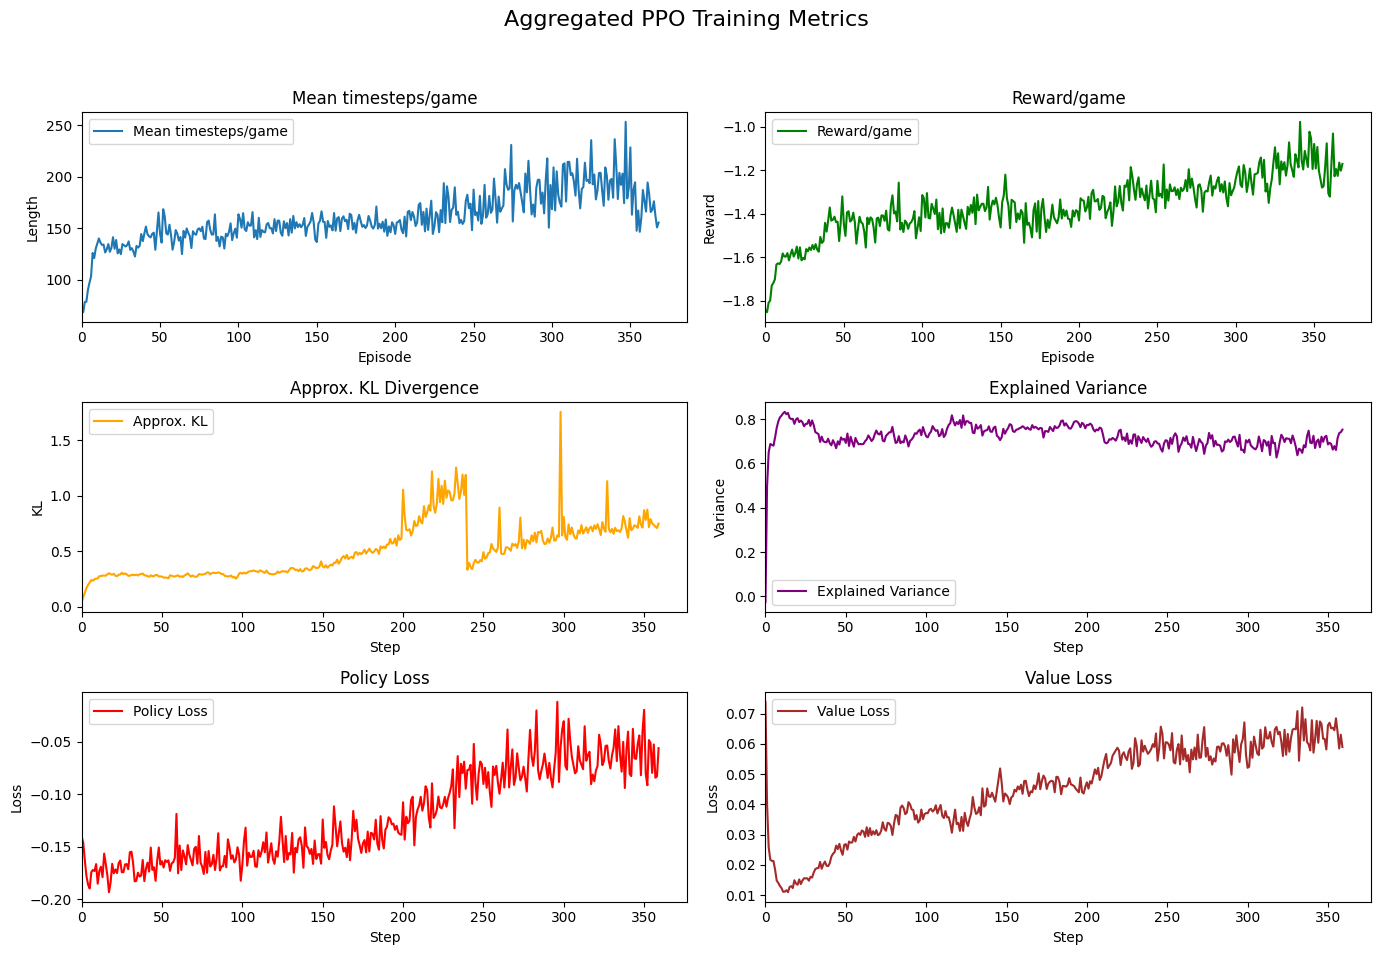

In [4]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle("Aggregated PPO Training Metrics", fontsize=16)

# Plot metrics
axs[0, 0].plot(ep_len, label="Mean timesteps/game")
axs[0, 0].set_title("Mean timesteps/game")
axs[0, 0].set_xlabel("Episode")
axs[0, 0].set_ylabel("Length")

axs[0, 1].plot(ep_rew, label="Reward/game", color='g')
axs[0, 1].set_title("Reward/game")
axs[0, 1].set_xlabel("Episode")
axs[0, 1].set_ylabel("Reward")

axs[1, 0].plot(approx_kl, label="Approx. KL", color='orange')
axs[1, 0].set_title("Approx. KL Divergence")
axs[1, 0].set_xlabel("Step")
axs[1, 0].set_ylabel("KL")

axs[1, 1].plot(explained, label="Explained Variance", color='purple')
axs[1, 1].set_title("Explained Variance")
axs[1, 1].set_xlabel("Step")
axs[1, 1].set_ylabel("Variance")

axs[2, 0].plot(loss, label="Policy Loss", color='red')
axs[2, 0].set_title("Policy Loss")
axs[2, 0].set_xlabel("Step")
axs[2, 0].set_ylabel("Loss")

axs[2, 1].plot(value_loss, label="Value Loss", color='brown')
axs[2, 1].set_title("Value Loss")
axs[2, 1].set_xlabel("Step")
axs[2, 1].set_ylabel("Loss")

# Improve layout and set x-axis limits to start at 0
for ax in axs.flat:
    ax.legend()
    ax.set_xlim(left=0)  # <-- This ensures x-axis starts at 0

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Including vertical lines, which mark the transistion from one between checkpoints

Total data points collected:
Episode Length: 369
Episode Reward: 369
Approx KL: 360
Explained Variance: 360
Loss: 360
Value Loss: 360


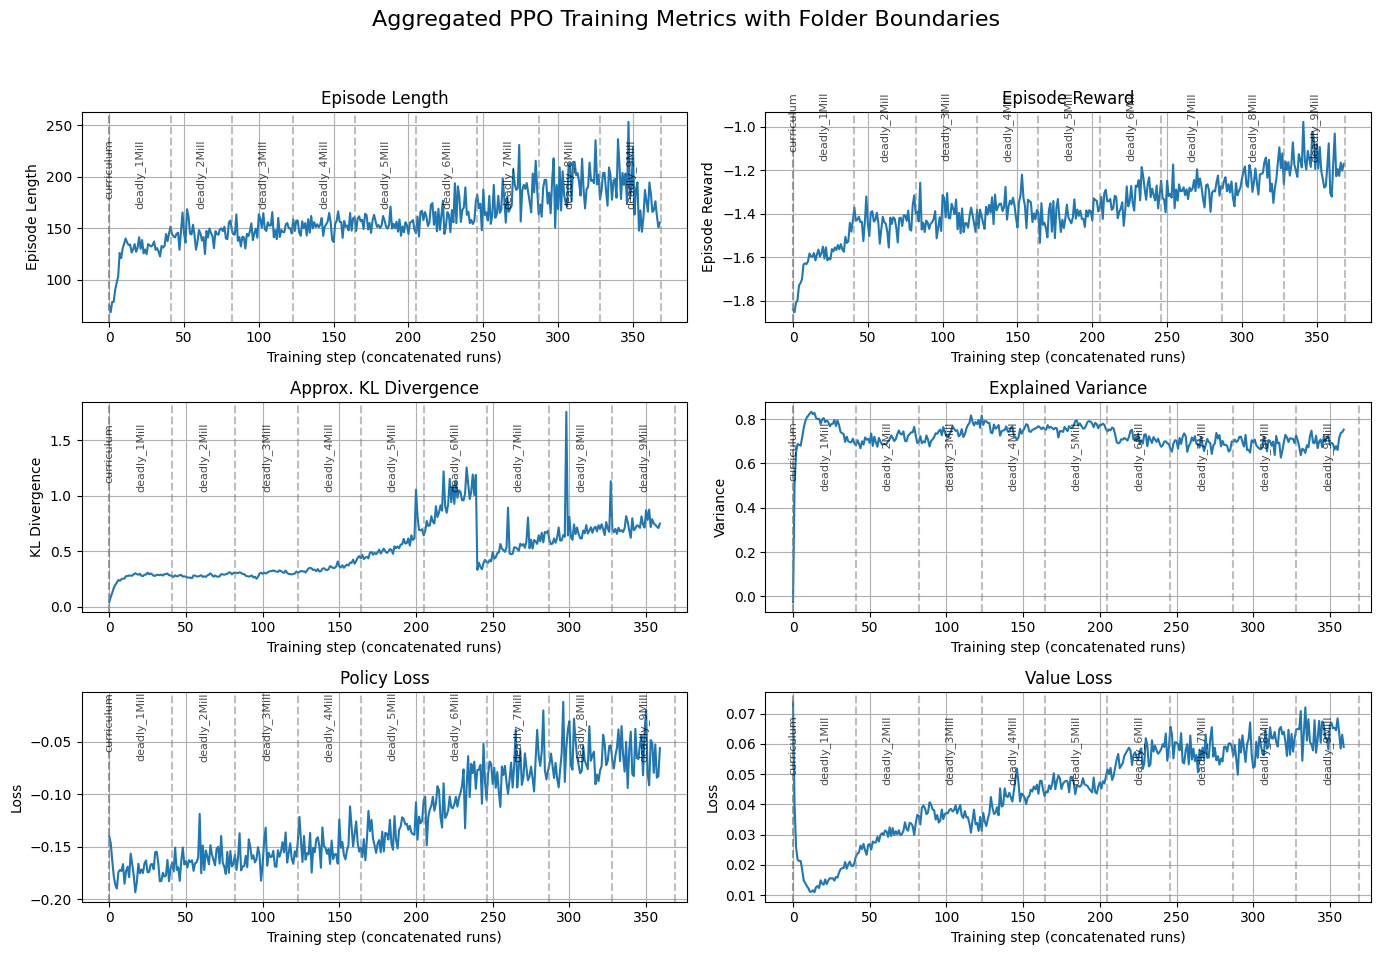

In [5]:
import os
import tensorflow as tf
from natsort import natsorted
import matplotlib.pyplot as plt

base_logdir = "ppo_vizdoom_tensorboard/"

ep_len = []
ep_rew = []
approx_kl = []
explained = []
loss = []
value_loss = []

folder_names = []
folder_data_points = []

def extract_metrics(event_file_path):
    local_ep_len = []
    local_ep_rew = []
    local_approx_kl = []
    local_explained = []
    local_loss = []
    local_value_loss = []

    for summary in tf.compat.v1.train.summary_iterator(event_file_path):
        for v in summary.summary.value:
            if v.tag == "rollout/ep_len_mean":
                local_ep_len.append(v.simple_value)
            elif v.tag == "rollout/ep_rew_mean":
                local_ep_rew.append(v.simple_value)
            elif v.tag == "train/approx_kl":
                local_approx_kl.append(v.simple_value)
            elif v.tag == "train/explained_variance":
                local_explained.append(v.simple_value)
            elif v.tag == "train/loss":
                local_loss.append(v.simple_value)
            elif v.tag == "train/value_loss":
                local_value_loss.append(v.simple_value)
    return (local_ep_len, local_ep_rew, local_approx_kl, local_explained, local_loss, local_value_loss)

for run_dir in natsorted(os.listdir(base_logdir)):
    full_run_path = os.path.join(base_logdir, run_dir)
    if os.path.isdir(full_run_path):
        folder_names.append(run_dir)

        folder_ep_len = []
        folder_ep_rew = []
        folder_approx_kl = []
        folder_explained = []
        folder_loss = []
        folder_value_loss = []

        for event_file in os.listdir(full_run_path):
            if "events.out.tfevents" in event_file:
                event_file_path = os.path.join(full_run_path, event_file)
                (lel, ler, lakl, lexp, lloss, lval_loss) = extract_metrics(event_file_path)
                folder_ep_len.extend(lel)
                folder_ep_rew.extend(ler)
                folder_approx_kl.extend(lakl)
                folder_explained.extend(lexp)
                folder_loss.extend(lloss)
                folder_value_loss.extend(lval_loss)

        ep_len.extend(folder_ep_len)
        ep_rew.extend(folder_ep_rew)
        approx_kl.extend(folder_approx_kl)
        explained.extend(folder_explained)
        loss.extend(folder_loss)
        value_loss.extend(folder_value_loss)

        folder_data_points.append(len(folder_ep_len))

print("Total data points collected:")
print(f"Episode Length: {len(ep_len)}")
print(f"Episode Reward: {len(ep_rew)}")
print(f"Approx KL: {len(approx_kl)}")
print(f"Explained Variance: {len(explained)}")
print(f"Loss: {len(loss)}")
print(f"Value Loss: {len(value_loss)}")

# Compute cumulative boundaries
boundaries = [0]
for length in folder_data_points:
    boundaries.append(boundaries[-1] + length)

fig, axs = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle("Aggregated PPO Training Metrics with Folder Boundaries", fontsize=16)

def plot_metric(ax, data, ylabel, title):
    ax.plot(data)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Training step (concatenated runs)")
    ax.grid(True)
    # Draw vertical lines at folder boundaries
    for b in boundaries:
        ax.axvline(x=b, color='gray', linestyle='--', alpha=0.5)
    # Add folder names at midpoints
    ylim = ax.get_ylim()
    for i in range(len(boundaries)-1):
        mid = (boundaries[i] + boundaries[i+1]) / 2
        ax.text(mid, ylim[1]*0.9, folder_names[i], rotation=90, ha='center', va='top', fontsize=8, alpha=0.7)

plot_metric(axs[0, 0], ep_len, "Episode Length", "Episode Length")
plot_metric(axs[0, 1], ep_rew, "Episode Reward", "Episode Reward")
plot_metric(axs[1, 0], approx_kl, "KL Divergence", "Approx. KL Divergence")
plot_metric(axs[1, 1], explained, "Variance", "Explained Variance")
plot_metric(axs[2, 0], loss, "Loss", "Policy Loss")
plot_metric(axs[2, 1], value_loss, "Loss", "Value Loss")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Aggregated tensorbaord metrics for all curriculum stages 

In [6]:
import os
import tensorflow as tf
from natsort import natsorted  # pip install natsort

# Root folder containing PPO_1/, PPO_2/, etc.
base_logdir = "ppo_vizdoom_tensorboard/curriculum"

# Initialize metric lists
ep_len_c = []
ep_rew_c = []
approx_kl_c = []
explained_C = []
loss_c = []
value_loss_c = []

# Helper function to extract values
def extract_metrics(event_file_path):
    for summary in tf.compat.v1.train.summary_iterator(event_file_path):
        for v in summary.summary.value:
            if v.tag == "rollout/ep_len_mean":
                ep_len_c.append(v.simple_value)
            elif v.tag == "rollout/ep_rew_mean":
                ep_rew_c.append(v.simple_value)
            elif v.tag == "train/approx_kl":
                approx_kl_c.append(v.simple_value)
            elif v.tag == "train/explained_variance":
                explained_C.append(v.simple_value)
            elif v.tag == "train/loss":
                loss_c.append(v.simple_value)
            elif v.tag == "train/value_loss":
                value_loss_c.append(v.simple_value)

# Traverse PPO_1, PPO_2, ... in natural order
for run_dir in natsorted(os.listdir(base_logdir)):
    full_run_path = os.path.join(base_logdir, run_dir)
    if os.path.isdir(full_run_path):
        for event_file in os.listdir(full_run_path):
            print(full_run_path)
            if "events.out.tfevents" in event_file:
                event_file_path = os.path.join(full_run_path, event_file)
                extract_metrics(event_file_path)

# You can now plot or further process the full training metrics
print("Total data points collected:")
print(f"Episode Length: {len(ep_len_c)}")
print(f"Episode Reward: {len(ep_rew_c)}")
print(f"Approx KL: {len(approx_kl_c)}")
print(f"Explained Variance: {len(explained_C)}")
print(f"Loss: {len(loss_c)}")
print(f"Value Loss: {len(value_loss_c)}")

ppo_vizdoom_tensorboard/curriculum/PPO_deadly1
ppo_vizdoom_tensorboard/curriculum/PPO_deadly2
ppo_vizdoom_tensorboard/curriculum/PPO_deadly3
ppo_vizdoom_tensorboard/curriculum/PPO_deadly4
ppo_vizdoom_tensorboard/curriculum/PPO_deadly5
Total data points collected:
Episode Length: 105
Episode Reward: 105
Approx KL: 100
Explained Variance: 100
Loss: 100
Value Loss: 100


# Plotting tensorbaord metrics for all curriculum stages 

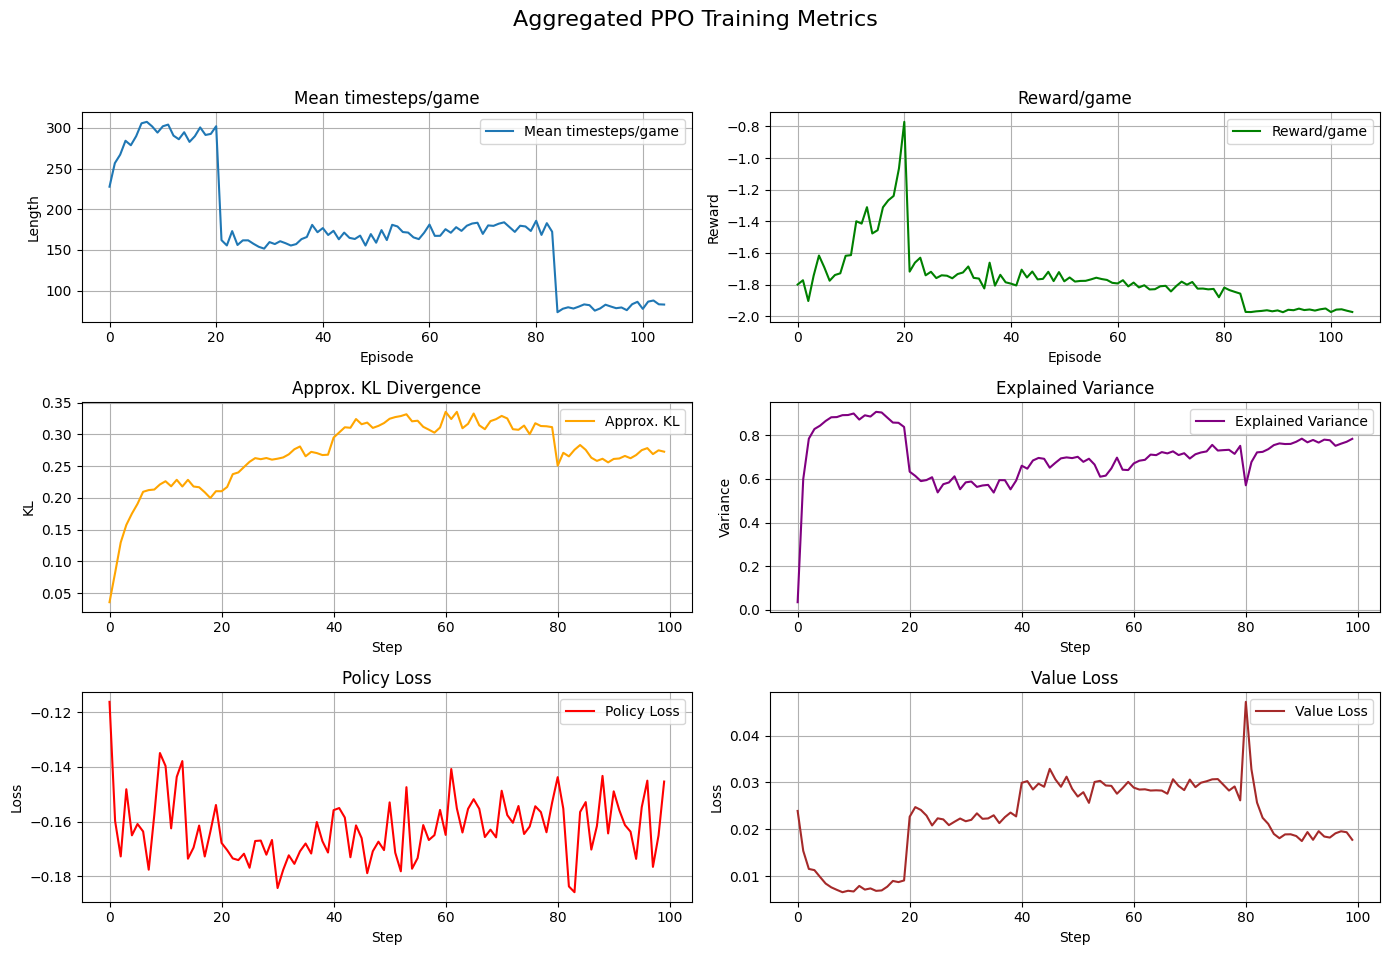

In [7]:
import matplotlib.pyplot as plt

plt.style.use("default")
# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle("Aggregated PPO Training Metrics", fontsize=16)

# Plot metrics
axs[0, 0].plot(ep_len_c, label="Mean timesteps/game")
axs[0, 0].set_title("Mean timesteps/game")
axs[0, 0].set_xlabel("Episode")
axs[0, 0].set_ylabel("Length")

axs[0, 1].plot(ep_rew_c, label="Reward/game", color='g')
axs[0, 1].set_title("Reward/game")
axs[0, 1].set_xlabel("Episode")
axs[0, 1].set_ylabel("Reward")

axs[1, 0].plot(approx_kl_c, label="Approx. KL", color='orange')
axs[1, 0].set_title("Approx. KL Divergence")
axs[1, 0].set_xlabel("Step")
axs[1, 0].set_ylabel("KL")

axs[1, 1].plot(explained_C, label="Explained Variance", color='purple')
axs[1, 1].set_title("Explained Variance")
axs[1, 1].set_xlabel("Step")
axs[1, 1].set_ylabel("Variance")

axs[2, 0].plot(loss_c, label="Policy Loss", color='red')
axs[2, 0].set_title("Policy Loss")
axs[2, 0].set_xlabel("Step")
axs[2, 0].set_ylabel("Loss")

axs[2, 1].plot(value_loss_c, label="Value Loss", color='brown')
axs[2, 1].set_title("Value Loss")
axs[2, 1].set_xlabel("Step")
axs[2, 1].set_ylabel("Loss")

# Improve layout
for ax in axs.flat:
    ax.grid(True)
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Comparing final agent(9 Mill steps), with agent having trained for same amount of steps as the curriculum one and the final curriculum agent

In [8]:
#Curriculum lvl5
import os
import tensorflow as tf
from natsort import natsorted  # Optional, but helpful if you want the first in natural order

# Path to the folder containing the TensorBoard event files
base_logdir = "ppo_vizdoom_tensorboard/curriculum/PPO_deadly5"

# Initialize metric lists
ep_len_c = []
ep_rew_c = []
approx_kl_c = []
explained_c = []
loss_c = []
value_loss_c = []

# Helper function to extract values from a single file
def extract_metrics(event_file_path):
    for summary in tf.compat.v1.train.summary_iterator(event_file_path):
        for v in summary.summary.value:
            if v.tag == "rollout/ep_len_mean":
                ep_len_c.append(v.simple_value)
            elif v.tag == "rollout/ep_rew_mean":
                ep_rew_c.append(v.simple_value)
            elif v.tag == "train/approx_kl":
                approx_kl_c.append(v.simple_value)
            elif v.tag == "train/explained_variance":
                explained_c.append(v.simple_value)
            elif v.tag == "train/loss":
                loss_c.append(v.simple_value)
            elif v.tag == "train/value_loss":
                value_loss_c.append(v.simple_value)

# Get the first matching event file (sorted naturally)
event_files = [f for f in os.listdir(base_logdir) if "events.out.tfevents" in f]
event_files = natsorted(event_files)

if event_files:
    first_event_file = event_files[0]
    event_file_path = os.path.join(base_logdir, first_event_file)
    print(f"Extracting from: {event_file_path}")
    extract_metrics(event_file_path)
else:
    print("No TensorBoard event files found.")


Extracting from: ppo_vizdoom_tensorboard/curriculum/PPO_deadly5/events.out.tfevents.1744554976.1ce6a5240aaa.215.12


In [9]:
#Standard best model
import os
import tensorflow as tf
from natsort import natsorted  # Optional, but helpful if you want the first in natural order

# Path to the folder containing the TensorBoard event files
base_logdir = "ppo_vizdoom_tensorboard/deadly_9Mill"

# Initialize metric lists
ep_len_s = []
ep_rew_s = []
approx_kl_s = []
explained_s = []
loss_s = []
value_loss_s = []

# Helper function to extract values from a single file
def extract_metrics(event_file_path):
    for summary in tf.compat.v1.train.summary_iterator(event_file_path):
        for v in summary.summary.value:
            if v.tag == "rollout/ep_len_mean":
                ep_len_s.append(v.simple_value)
            elif v.tag == "rollout/ep_rew_mean":
                ep_rew_s.append(v.simple_value)
            elif v.tag == "train/approx_kl":
                approx_kl_s.append(v.simple_value)
            elif v.tag == "train/explained_variance":
                explained_s.append(v.simple_value)
            elif v.tag == "train/loss":
                loss_c.append(v.simple_value)
            elif v.tag == "train/value_loss":
                value_loss_s.append(v.simple_value)

# Get the first matching event file (sorted naturally)
event_files = [f for f in os.listdir(base_logdir) if "events.out.tfevents" in f]
event_files = natsorted(event_files)

if event_files:
    first_event_file = event_files[0]
    event_file_path = os.path.join(base_logdir, first_event_file)
    print(f"Extracting from: {event_file_path}")
    extract_metrics(event_file_path)
else:
    print("No TensorBoard event files found.")


Extracting from: ppo_vizdoom_tensorboard/deadly_9Mill/events.out.tfevents.1745498614.24bde8b81977.1084.12


In [10]:
#Directly trained agent on lvl_5 on same amount of training steps as curriculum
import os
import tensorflow as tf
from natsort import natsorted  # Optional, but helpful if you want the first in natural order

# Path to the folder containing the TensorBoard event files
base_logdir = "ppo_vizdoom_tensorboard/deadly_3Mill"

# Initialize metric lists
ep_len_s5 = []
ep_rew_s5 = []
approx_kl_s5 = []
explained_s5 = []
loss_s5 = []
value_loss_s5 = []

# Helper function to extract values from a single file
def extract_metrics(event_file_path):
    for summary in tf.compat.v1.train.summary_iterator(event_file_path):
        for v in summary.summary.value:
            if v.tag == "rollout/ep_len_mean":
                ep_len_s5.append(v.simple_value)
            elif v.tag == "rollout/ep_rew_mean":
                ep_rew_s5.append(v.simple_value)
            elif v.tag == "train/approx_kl":
                approx_kl_s5.append(v.simple_value)
            elif v.tag == "train/explained_variance":
                explained_s5.append(v.simple_value)
            elif v.tag == "train/loss":
                loss_c.append(v.simple_value)
            elif v.tag == "train/value_loss":
                value_loss_s5.append(v.simple_value)

# Get the first matching event file (sorted naturally)
event_files = [f for f in os.listdir(base_logdir) if "events.out.tfevents" in f]
event_files = natsorted(event_files)

if event_files:
    first_event_file = event_files[0]
    event_file_path = os.path.join(base_logdir, first_event_file)
    print(f"Extracting from: {event_file_path}")
    extract_metrics(event_file_path)
else:
    print("No TensorBoard event files found.")


Extracting from: ppo_vizdoom_tensorboard/deadly_3Mill/events.out.tfevents.1745399999.cd17abbba94c.341.12


# Plotting the comparison

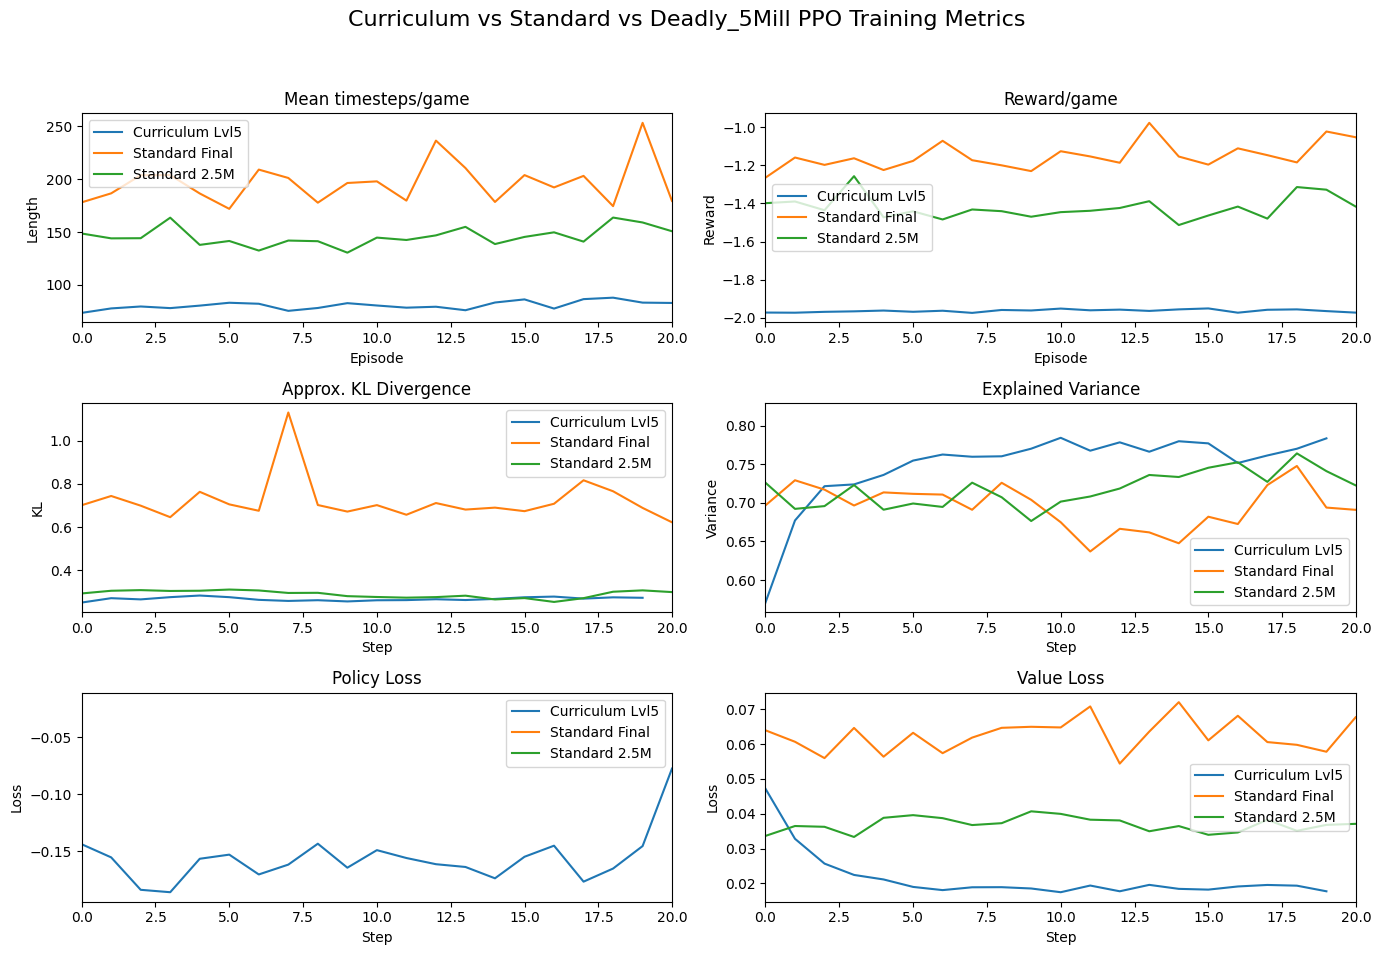

In [11]:
import matplotlib.pyplot as plt



fig, axs = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle("Curriculum vs Standard vs Deadly_5Mill PPO Training Metrics", fontsize=16)

# Episode Length
axs[0, 0].plot(ep_len_c, label="Curriculum Lvl5")
axs[0, 0].plot(ep_len_s, label="Standard Final")
axs[0, 0].plot(ep_len_s5, label="Standard 2.5M")
axs[0, 0].set_title("Mean timesteps/game")
axs[0, 0].set_xlabel("Episode")
axs[0, 0].set_ylabel("Length")
axs[0, 0].set_xlim(0, 20)
axs[0, 0].legend()

# Episode Reward
axs[0, 1].plot(ep_rew_c, label="Curriculum Lvl5")
axs[0, 1].plot(ep_rew_s, label="Standard Final")
axs[0, 1].plot(ep_rew_s5, label="Standard 2.5M")
axs[0, 1].set_title("Reward/game")
axs[0, 1].set_xlabel("Episode")
axs[0, 1].set_ylabel("Reward")
axs[0, 1].set_xlim(0, 20)
axs[0, 1].legend()

# Approx KL Divergence
axs[1, 0].plot(approx_kl_c, label="Curriculum Lvl5")
axs[1, 0].plot(approx_kl_s, label="Standard Final")
axs[1, 0].plot(approx_kl_s5, label="Standard 2.5M")
axs[1, 0].set_title("Approx. KL Divergence")
axs[1, 0].set_xlabel("Step")
axs[1, 0].set_ylabel("KL")
axs[1, 0].set_xlim(0, 20)
axs[1, 0].legend()

# Explained Variance
axs[1, 1].plot(explained_c, label="Curriculum Lvl5")
axs[1, 1].plot(explained_s, label="Standard Final")
axs[1, 1].plot(explained_s5, label="Standard 2.5M")
axs[1, 1].set_title("Explained Variance")
axs[1, 1].set_xlabel("Step")
axs[1, 1].set_ylabel("Variance")
axs[1, 1].set_xlim(0, 20)
axs[1, 1].legend()

# Policy Loss
axs[2, 0].plot(loss_c, label="Curriculum Lvl5")
axs[2, 0].plot(loss_s, label="Standard Final")
axs[2, 0].plot(loss_s5, label="Standard 2.5M")
axs[2, 0].set_title("Policy Loss")
axs[2, 0].set_xlabel("Step")
axs[2, 0].set_ylabel("Loss")
axs[2, 0].set_xlim(0, 20)
axs[2, 0].legend()

# Value Loss
axs[2, 1].plot(value_loss_c, label="Curriculum Lvl5")
axs[2, 1].plot(value_loss_s, label="Standard Final")
axs[2, 1].plot(value_loss_s5, label="Standard 2.5M")
axs[2, 1].set_title("Value Loss")
axs[2, 1].set_xlabel("Step")
axs[2, 1].set_ylabel("Loss")
axs[2, 1].set_xlim(0, 20)
axs[2, 1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [12]:
%%writefile ppo_pretraining.py
import gymnasium
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import DummyVecEnv,make_vec_env
from vizdoom_env import create_vizdoom_env  
import os 

# environment for each map
def make_env(map_name):
    """
    Utility function for creating a single environment.
    :param map_name: Name of the map configuration.
    :return: Callable function to create the environment.
    """
    return lambda: create_vizdoom_env(map=map_name)  # Ensure your `create_vizdoom_env` handles the `map` argument

if __name__ == '__main__':
    model_path = "ppo_vizdoom_model.zip"
    # Use SubprocVecEnv to handle multiple parallel environments
    envs = make_vec_env(lambda: create_vizdoom_env(), n_envs=12)  # Pass a callable
    # envs = DummyVecEnv([make_env(map_name) for map_name in maps])

    print(os.path.exists(model_path))

    if os.path.exists(model_path):
        model = PPO.load(model_path, envs,learning_rate=1e-4, verbose=1,tensorboard_log="./ppo_vizdoom_tensorboard/", device="cuda")
        model.set_env(env=envs)
    else:
        # This escalted quickly, but we in the end we tried to use the same hyperparameters that we found online in a similar project. This might have a huge influence on the whole performance
        model = PPO("CnnPolicy",
            envs,
            n_steps=2048,
            learning_rate=1e-4,
            ent_coef=0.01,
            clip_range=0.2,
            gamma=0.99,
            gae_lambda=0.95,
            verbose=1,
            tensorboard_log="./ppo_vizdoom_tensorboard/",
            device="cuda")
    
    timesteps= 2500000
    model.learn(timesteps,tb_log_name=f"PPO")
    model.save(f"{model_path}")
    envs.close()


Overwriting ppo_pretraining.py


In [14]:
!git remote -v

origin	https://github.com/leandergmeiner/studienarbeit.git (fetch)
origin	https://github.com/leandergmeiner/studienarbeit.git (push)


In [15]:
!git lfs install
!git lfs track "*.zip"

Updated git hooks.
Git LFS initialized.
"*.zip" already supported


In [20]:
!git checkout -b pretraining/stable_baselines_PPO_deadly_corridor
!git add -A
!git add .gitattributes
!git commit -m "Final commit, Still some problems with the map"
!git push -u origin pretraining/stable_baselines_PPO_deadly_corridor

fatal: A branch named 'pretraining/stable_baselines_PPO_deadly_corridor' already exists.
On branch pretraining/stable_baselines_PPO_deadly_corridor
nothing to commit, working tree clean
Username for 'https://github.com': ^C


In [39]:
!git push -u origin pretraining/stable_baselines_PPO_deadly_corridor

Uploading LFS objects: 100% (14/14), 1.0 GB | 90 MB/s, done.                    
Enumerating objects: 235, done.
Counting objects: 100% (235/235), done.
Delta compression using up to 4 threads
Compressing objects: 100% (222/222), done.
Writing objects: 100% (234/234), 68.95 MiB | 18.72 MiB/s, done.
Total 234 (delta 17), reused 83 (delta 9), pack-reused 0
remote: Resolving deltas: 100% (17/17), done.
remote: warning: See https://gh.io/lfs for more information.
remote: warning: File test_run.mp4 is 51.97 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB
remote: warning: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.
remote: 
remote: Create a pull request for 'pretraining/stable_baselines_PPO_deadly_corridor' on GitHub by visiting:
remote:      https://github.com/leandergmeiner/studienarbeit/pull/new/pretraining/stable_baselines_PPO_deadly_corridor
remote: 
remote: GitHub found 15 vulnerabilities on leandergme